In [81]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [4]:
before_files = glob('/data03/hotspot/before/result/*.csv')
after_files = glob('/data03/hotspot/after/result/*.csv')

In [6]:
def get_results(files):
    ent_result_dict = {}
    var_result_dict = {}
    for file in files:
        temp_name = file.split('/')[-1].split('_')
        p = float(temp_name[1])
        k = float(temp_name[2].split('.c')[0])

        temp = pd.read_csv(file)
        ent_result_dict[(p,k)] = (temp['ent_jsd'].mean(), temp['ent_jsd'].std())
        var_result_dict[(p,k)] = (temp['var_jsd'].mean(), temp['var_jsd'].std())
    
    return ent_result_dict, var_result_dict

In [12]:
before_ent_result_dict, before_var_result_dict = get_results(before_files)
after_ent_result_dict, after_var_result_dict = get_results(after_files)

In [13]:
def find_best_results(var_result_dict):
    ks = list(var_result_dict.keys())
    var_list = np.array([var_result_dict[k][0] for k in ks])
    best_p, best_k = ks[np.argmin(var_list)]
    
    return best_p, best_k

In [14]:
before_best_p, before_best_k = find_best_results(before_var_result_dict)
after_best_p, after_best_k = find_best_results(after_var_result_dict)

In [15]:
before_best_p, before_best_k

(0.63, 0.8)

In [16]:
after_best_p, after_best_k

(0.66, 1.0)

In [17]:
ps = [np.round(x,2) for x in np.linspace(0,1, 101)]
ks = [np.round(x,2) for x in np.linspace(0.05, 5 , 100)]

In [19]:
var_jsds_before = np.zeros((len(ps), len(ks)))
for i, p in enumerate(ps):
    for j, k in enumerate(ks):
        var_jsds_before[i][j] = before_var_result_dict[(p,k)][0]

var_jsds_after = np.zeros((len(ps), len(ks)))
for i, p in enumerate(ps):
    for j, k in enumerate(ks):
        var_jsds_after[i][j] = after_var_result_dict[(p,k)][0]

In [37]:
before_file = [file for file in before_files if '{}_{}.'.format(before_best_p, before_best_k) in file][0]
before_min_idx = pd.read_csv(before_file)['var_jsd'].argmin()

In [38]:
after_file = [file for file in after_files if '{}_{}.'.format(after_best_p, after_best_k) in file][0]
after_min_idx = pd.read_csv(after_file)['var_jsd'].argmin()

In [76]:
before_path = '/'.join(before_file.split('/')[:4])
after_path = '/'.join(after_file.split('/')[:4])

In [77]:
from collections import Counter
def get_pdf(points, bins):
    temp_counter = Counter(np.digitize(points, bins))
    temp_sum = sum(temp_counter.values())
    temp_ys = [temp_counter.get(i, 0) /temp_sum for i in range (1, len(bins))]
    
    return temp_ys

In [78]:
data_ent = np.load('../data/derived/before/entropy_data.npy')
data_var = np.load('../data/derived/before/varaince_data.npy')

ent_bins = np.linspace(0, 2.2, 30 + 1)
var_bins = np.linspace(0, 24, 30 + 1)

In [82]:
FONT_PATH = '../assets/Helvetica.ttf'

In [167]:
def draw_best_simulation_result(path, best_p, best_k, min_idx, data_ent, data_var, ent_bins, var_bins, font_path, img_path):
    best_ent = np.load('{}/entropy/entropy_{}_{}.npy'.format(path, best_p, best_k))[min_idx]
    best_var = np.load('{}/variance/variance_{}_{}.npy'.format(path, best_p, best_k))[min_idx]
    
    ent_xs = [(ent_bins[i] + ent_bins[i + 1])/2 for i in range(len(ent_bins) - 1)]
    var_xs = [(var_bins[i] + var_bins[i + 1])/2 for i in range(len(var_bins) - 1)]

    data_var_pdf = get_pdf(data_var, var_bins)
    data_ent_pdf = get_pdf(data_ent, ent_bins)

    best_var_pdf = get_pdf(best_var, var_bins)
    best_ent_pdf = get_pdf(best_ent, ent_bins)
    
    plt.rcParams['figure.figsize'] = (12.0, 6.0)

    prop = font_manager.FontProperties(fname=font_path, size=22)
    small_prop = font_manager.FontProperties(fname=font_path, size=18)
    tiny_prop = font_manager.FontProperties(fname=font_path, size=15)

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(var_xs, data_var_pdf, '-o', markerfacecolor='white', color='darkorange', label='data')
    ax1.plot(var_xs, best_var_pdf, '-o', markerfacecolor='white', color='cornflowerblue', label='Simulation')
    ax1.set_xlabel('Locational Variance',fontsize=20)

    ax2.plot(ent_xs, data_ent_pdf, '-o', markerfacecolor='white', color='darkorange', label='data')
    ax2.plot(ent_xs, best_ent_pdf, '-o', markerfacecolor='white', color='cornflowerblue', label='Simulation')
    ax2.set_xlabel('Entropy', fontsize=20)

    plt.legend(fontsize=18, frameon=False)

    for label in ax1.get_xticklabels():
        label.set_fontproperties(tiny_prop)
    for label in ax1.get_yticklabels():
        label.set_fontproperties(tiny_prop)
    for label in ax2.get_xticklabels():
        label.set_fontproperties(tiny_prop)
    for label in ax2.get_yticklabels():
        label.set_fontproperties(tiny_prop)
    plt.savefig(img_path, bbox_inches='tight')
    plt.show()

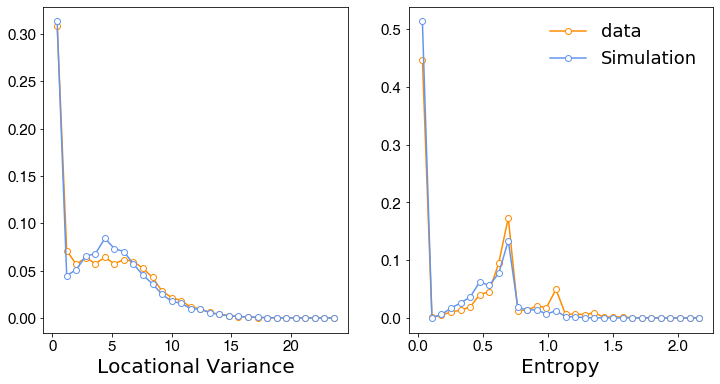

In [168]:
draw_best_simulation_result(before_path, before_best_p, before_best_k, before_min_idx, data_ent, data_var, ent_bins, var_bins, FONT_PATH, 'before.pdf')

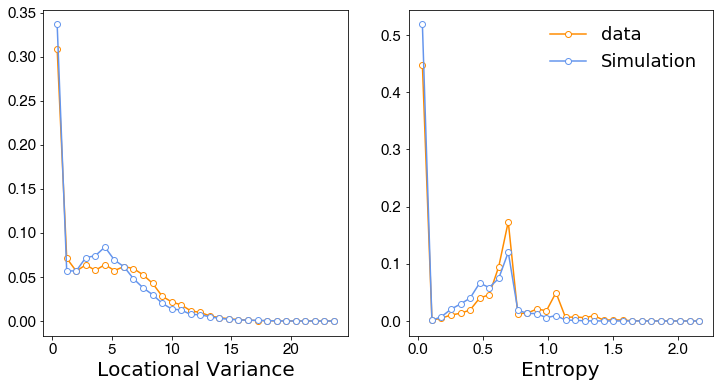

In [169]:
draw_best_simulation_result(after_path, after_best_p, after_best_k, after_min_idx, data_ent, data_var, ent_bins, var_bins, FONT_PATH, 'after.pdf')

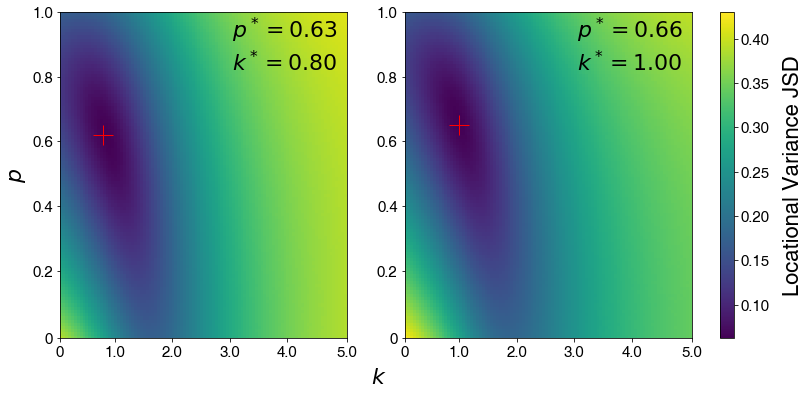

In [184]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13.0, 6.0)

prop = font_manager.FontProperties(fname=FONT_PATH, size=22)
small_prop = font_manager.FontProperties(fname=FONT_PATH, size=18)
tiny_prop = font_manager.FontProperties(fname=FONT_PATH, size=15)

fig, (ax1, ax2) = plt.subplots(1, 2)

im = ax1.pcolormesh(var_jsds_before, vmin=0.062, vmax=0.43)
im_ = ax2.pcolormesh(var_jsds_after, vmin=0.062, vmax=0.43)
for ax in ax1, ax2:
    ax.set_yticks([0, 21, 41, 61, 81, 101])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontproperties=tiny_prop)
    ax.set_xticks([0, 19, 39, 59, 79, 100])
    ax.set_xticklabels([0, ks[19], ks[39], ks[59], ks[79], ks[99]], fontproperties=tiny_prop)
ax1.set_ylabel(r'$p$', fontproperties=prop)
fig.text(0.465, 0.02, r'$k$', ha='center', fontproperties=prop)

min_p, min_k = np.unravel_index(var_jsds_before.argmin(), var_jsds_before.shape)
ax1.plot(min_k, min_p, 'r+', markersize=20)
ax1.text(60, 93, r'$p^*={0:.2f}$'.format(before_best_p),  fontproperties=prop)
ax1.text(60, 83, r'$k^*={0:.2f}$'.format(before_best_k),  fontproperties=prop)

min_p, min_k = np.unravel_index(var_jsds_after.argmin(), var_jsds_after.shape)
ax2.plot(min_k, min_p, 'r+', markersize=20)
ax2.text(60, 93, r'$p^*={0:.2f}$'.format(after_best_p),  fontproperties=prop)
ax2.text(60, 83, r'$k^*={0:.2f}$'.format(after_best_k),  fontproperties=prop)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.125, 0.015, 0.755])
cbar = fig.colorbar(im, cax=cbar_ax)


for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(tiny_prop)
cbar.ax.set_ylabel("Locational Variance JSD", fontproperties=prop, labelpad=13)
plt.savefig('total.pdf', bbox_inches='tight')

In [125]:
np.argmin(var_jsds_before)

6315

In [128]:
np.unravel_index(var_jsds_before.argmin(), var_jsds_before.shape)

(63, 15)

In [100]:
np.max(var_jsds_before)

0.4120968827583823

In [101]:
np.max(var_jsds_after)

0.4284921557055286